# Function to track singular values a vectors from SVD

This notebooks contains the function for tracking the singular values and vectors from the SVD of an array of matrices dependent on a parameter. At the end, I included an example for a particular matrix. This code can be adapted, of course, to compute the singular modes of the absorption matrix $Q$.

Last time modified: 27.04.2025

## Necessary libraries:
- Numpy for vector functions, as well for general math functions
- Matplotlib for plotting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as lg
from scipy.optimize import linear_sum_assignment
import matplotlib.colors as colors
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Introduction to the algorithm

Given a matrix, numerically computing its spectrum of singular values and vectors is straightforward. However, in our specific case of interest, where the absorption matrix depends on frequency, calculating the thermal emission spectrum, for instance, requires an algorithm to track the different absorption modes as a function of frequency, as crossings between modes may occur for certain parameter values. In general, let us consider a matrix $A$ dependent on a parameter $\varrho$, which can be decomposed as $A = K \gamma G^\dagger$. The singular vectors of $A$ are the rows of the matrix $G^\dagger$, namely

$$
G^\dagger = \begin{pmatrix}
(g^1) ^\dagger\\
(g^2) ^\dagger\\
\vdots\\
(g^n) ^\dagger
\end{pmatrix} = \begin{pmatrix}
g^1_1 & g^1_2  & \cdots & g^1_n  \\
g^2_1 & g^2_2  & \cdots & g^2_n  \\  
\vdots & \vdots &  \ldots & \vdots \\
g^n_1 & g^n_2  & \cdots & g^n_n
\end{pmatrix}^*,$$
while the corresponding singular values are the elements of the diagonal of $\gamma$. Let $G(\varrho)$ and $\tilde{G}(\varrho_>)$ be the matrices containing the singular values associated with two nearby values of the parameter $\varrho$. The singular values associated with a given value of the parameter $\varrho$ form an orthogonal set of vectors, however, they are not necessarily orthogonal to those corresponding to the next value $\varrho_>$. Assuming that the singular vectors vary adiabatically with respect to the parameter $\varrho$, the corresponding modes of $\tilde{G}(\varrho_>)$ will be those maximizing the projection with the vectors of $G(\varrho)$. To achieve this, I define the overlap matrix $O= G(\varrho)^\dagger \tilde{G}(\varrho_>)$ which contains the inner products of the singular vectors of $G^\dagger(\varrho)$ in the rows and those of $\tilde{G}(\varrho_>)$ in the columns, namely

$$ O = \begin{pmatrix}
g^1_1 & g^1_2  & \cdots & g^1_n  \\
g^2_1 & g^2_2  & \cdots & g^2_n  \\  
\vdots & \vdots &  \ldots & \vdots \\
g^n_1 & g^n_2  & \cdots & g^n_n
\end{pmatrix}^* \begin{pmatrix}
\tilde{g}^1_1 & \tilde{g}^2_1  & \cdots & \tilde{g}^n_1  \\
\tilde{g}^1_2 & \tilde{g}^2_2  & \cdots & \tilde{g}^n_2  \\  
\vdots & \vdots &  \ldots & \vdots \\
\tilde{g}^1_n & \tilde{g}^2_n  & \cdots & \tilde{g}^n_n
\end{pmatrix} = \begin{pmatrix}
(g^1)^*\cdot\tilde{g}^1  & (g^1)^*\cdot\tilde{g}^2  & \cdots & (g^1)^*\cdot\tilde{g}^n   \\
(g^2)^*\cdot\tilde{g}^1  & (g^2)^*\cdot\tilde{g}^2  & \cdots & (g^2)^*\cdot\tilde{g}^n    \\  
\vdots & \vdots &  \ldots & \vdots \\
(g^n)^*\cdot\tilde{g}^1  & (g^n)^*\cdot\tilde{g}^2  & \cdots & (\tilde{g}^n)^*\cdot\tilde{g}^n  
\end{pmatrix}.$$

The problem of finding the correspondence between the states reduces to the so-called $\textit{linear assignment problem}$ which consists of finding the optimum matching between two sets of instances (or technically called bipartite graphs), e.g., workers and tasks or machines and activities, such that they fulfill a specific rule, e.g., minimize the cost. Since this is a well-known problem in combinatorial optimization, algorithms to solve this problem are already implemented in different libraries.

# Algorithm
The function SVD receives as inputs the array `paramrange` which is an array containingg the parameter `q` that is the parameter what the matrices depend on, as well as the array of matrices `Matrices`, where each one is a square matrix of size $n\times n$.
Initially, the SVD for the first matrix in `Matrices` is computed, from this, the singular modes are identified and tracked. 
Subsequently, the SVD of every matrix in `Matrices`the SVD is computed, and the overlap matrix `ov_matrix` is built from the immediate value of the parameter and the previous one. With the function `linear_sum_assignment` from Numpy, the correct modes are chosen and added to the array of singular values.
The function returns two arrays: the first one (`sorted_levels`) is a matrix whose number of rows is the number of values in `paramrange` and the number of columns is the size of the matrix $n$. The second output (`sorted_vecs`) is a matrix, whose elements are matrices, each one containing the singular vectors. 
To get the n-th singular value of the $f$-th value in `paramrange`, one should use `sortedvals[f][n]`. Analogously for the n-th singular vector of the $f$-th value in `paramrange`, one calls `sortedvecs[f][n]`.

In [2]:
def SVD(paramrange, Matrices):
    K, gamma, G = lg.svd(Matrices[0]) #Computing the SVD for the first matrix in Matrices
    val1, vec1 = gamma, G
    sorted_levels = [val1] #Storing the singular values
    sorted_vecs = [vec1] #Storing the singular vectors
        
    for f in range(1,len(paramrange)): #Computing the SVD for the remaining matrices in Matrices
        K, gamma, G = lg.svd(Matrices[f])
        val2, vec2 = gamma, G 
        ov_matrix = np.abs(vec1 @ vec2.T.conj()) #Computing the overlap matrix
        optimal = linear_sum_assignment(-ov_matrix)[1] 
        sorted_levels.append(val2[optimal]) #Sorting and storing the singular values according to the linear_sum_assignment
        vec1 = vec2[optimal,:] #Sorting the singular vectors (rows of G) according to the linear_sum_assignment
        sorted_vecs.append(vec1) #Storing the singular vectors 

    return [sorted_levels, sorted_vecs]

## Example
Let us track the singular modes for the matrix

$$ M = \begin{pmatrix} 
\sin(q) & -q\cos(q)& q -2i\\
-q\sin(q) & q& \tan(q) \\
q& -2\cos(q)&4 
\end{pmatrix}, $$

that depends on the parameter $q$, in the range $q \in [0,10]$.

In [8]:
def MatricesExample(q): #Here I define the matrix 
    return np.matrix([[np.sin(q),-np.cos(q)*q, q-2j], [-q*np.sin(q), q, np.tan(q)], [q, -2*np.cos(q),4]])

paramrange = np.linspace(0,10,100) #Parameter range
Matrices = np.array([MatricesExample(q) for q in paramrange]) #Array of matrices


In [9]:
vals, vecs = SVD(paramrange, Matrices)

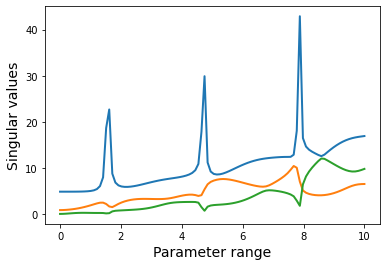

In [10]:
plt.figure(figsize = (6,4))
plt.plot(paramrange, vals, linewidth = 2)
plt.xlabel("Parameter range", fontsize = 14)
plt.ylabel("Singular values", fontsize = 14)
plt.show()